In [3]:

!pip install kaggle --quiet

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
# Step 2: Download dataset from Kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

# Unzip the dataset into /content/dataset
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d dataset

# View dataset structure
!ls dataset
!ls dataset/lung_colon_image_set


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
lung_colon_image_set
colon_image_sets  lung_image_sets


In [6]:
import os

base_path = "dataset/lung_colon_image_set"
for folder in os.listdir(base_path):
    print(folder, "->", os.listdir(os.path.join(base_path, folder))[:3])


colon_image_sets -> ['colon_n', 'colon_aca']
lung_image_sets -> ['lung_scc', 'lung_n', 'lung_aca']


In [8]:
import os, shutil, random

# Paths
colon_path = "dataset/lung_colon_image_set/colon_image_sets"
lung_path = "dataset/lung_colon_image_set/lung_image_sets"
dst_base = "small_dataset"

# Create destination
os.makedirs(dst_base, exist_ok=True)

# Combine both colon and lung classes
all_classes = []
for base in [colon_path, lung_path]:
    for cls in os.listdir(base):
        all_classes.append(os.path.join(base, cls))

# Copy up to 1000 samples per class
for cls_path in all_classes:
    cls_name = os.path.basename(cls_path)
    dst = os.path.join(dst_base, cls_name)
    os.makedirs(dst, exist_ok=True)

    files = os.listdir(cls_path)
    sample = random.sample(files, min(1000, len(files)))  # limit to 1000
    for f in sample:
        shutil.copy(os.path.join(cls_path, f), os.path.join(dst, f))

print("✅ Combined small dataset created with colon + lung classes!")


✅ Combined small dataset created with colon + lung classes!


In [9]:
!ls small_dataset


colon_aca  colon_n  lung_aca  lung_n  lung_scc


In [10]:
import os, shutil
from sklearn.model_selection import train_test_split

src_base = "small_dataset"
train_dir = "data/train"
val_dir = "data/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for cls in os.listdir(src_base):
    cls_path = os.path.join(src_base, cls)
    files = os.listdir(cls_path)
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(val_dir, cls, f))

print("✅ Train/Validation split complete!")


✅ Train/Validation split complete!


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.4895 - loss: 1.1380 - val_accuracy: 0.7090 - val_loss: 0.6454
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - accuracy: 0.6714 - loss: 0.6775 - val_accuracy: 0.8170 - val_loss: 0.4568
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.7230 - loss: 0.6043 - val_accuracy: 0.7960 - val_loss: 0.4802
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.7335 - loss: 0.5876 - val_accuracy: 0.6900 - val_loss: 0.5821
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.7835 - loss: 0.4936 - val_accuracy: 0.7780 - val_loss: 0.4460
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.7984 - loss: 0.4656 - val_accuracy: 0.7520 - val_loss: 0.4580
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.7980 - loss: 0.4420 - val_accuracy: 0.8370 - val_loss: 0.3754
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.8396 - loss: 0

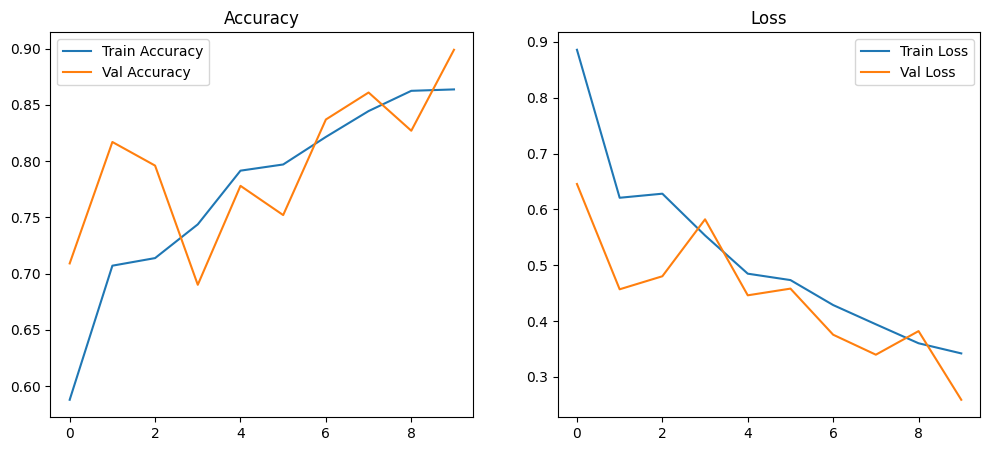

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


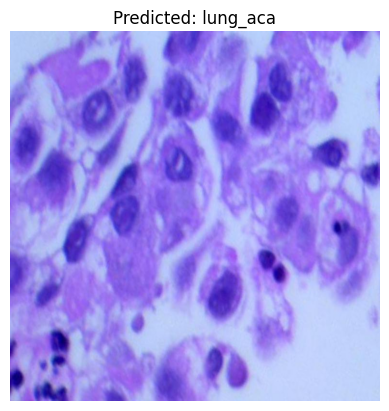

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

classes = list(train_gen.class_indices.keys())

img_path = os.path.join(val_dir, random.choice(classes), random.choice(os.listdir(os.path.join(val_dir, random.choice(classes)))))
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = classes[np.argmax(pred)]

plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {pred_class}")
plt.axis('off')
plt.show()


In [16]:
# Save model in HDF5 format
model.save("lung_cancer_cnn.h5")

# Download to your computer
from google.colab import files
files.download("lung_cancer_cnn.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>